### [Computational Performance](https://scikit-learn.org/stable/computing/computational_performance.html)

### Latency - Bulk vs Atomic Mode

- In general doing predictions in bulk (many instances at the same time) is more efficient for a number of reasons (branching predictability, CPU cache, linear algebra optimizations, etc.). 

### Latency vs Validation Overhead

- Scikit-learn's data validations increase the overhead per call to `predict` and similar functions. 

- In particular: checking for finite (not NaN or Infinite) features  involves a full pass over the data. If you know your data is acceptable, *you can suppress finiteness checking* by setting the environment variable `SKLEARN_ASSUME_FINITE` to a non-empty string before importing scikit-learn -  or configure it in Python with `set_config`. 

- For fine-tuned control of this feature:

`with sklearn.config_context(assume_finite=True):
    pass <learning/prediction method here, with reduced validation>`

### Latency vs Number of Features

- A matrix of $M$ samples with $N$ features has a memory footprint of $O(NM)$. This means the number of basic math operations increases too. (See the prediction time vs #features graph, below.) 

### Latency vs Input Datatypes

- [SciPy provides sparse matrix structures](https://docs.scipy.org/doc/scipy/reference/sparse.html), which are much more memory efficient. A non-zero value in a **CSR** or **CSC** sparse matrix will consume, on average:
    - a position (integer, 32b)
    - a value (floating point, 64)
    - row or column ID (integer, 32b)
    
- Math operations on dense data structures can leverage vector operations and multithreading in **BLAS**, and usually results in fewer CPU cache misses.

- As a general rule: if the data sparsity ratio is >90%, consider using a sparse format. 

### Latency vs Feature Extraction

- Most scikit-learn use compiled Cython extensions or optimized computing libraries. However, the feature extraction process (i.e. turning raw data like database rows or network packets into numpy arrays) governs the overall prediction time in most real-world applications. 

- Example: the data prep for the Reuters text classification task (reading and parsing SGML files, tokenizing the text and hashing it into a common vector space) takes **100-500X** more time than the prediction code.

### [Example: Model Complexity](https://scikit-learn.org/stable/auto_examples/applications/plot_model_complexity_influence.html)

- Compare SGD Classifier (stochastic gradient descent) vs NuSVR (Nu support vector regression) vs Gradient Boosting Regressor (additive model, iterative).

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm import NuSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hamming_loss

- regressions: use diabetes toy dataset.
- classifications: use 20newsgroups text dataset.

In [6]:
def generate_data(case):
    if case == 'regression':
        X, y = datasets.load_diabetes(return_X_y=True)
    elif case == 'classification':
        X, y = datasets.fetch_20newsgroups_vectorized(subset='all',
                                                      return_X_y=True)
    X, y             = shuffle(X, y)
    offset           = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test   = X[offset:], y[offset:]

    data = {'X_train': X_train, 
            'X_test': X_test, 
            'y_train': y_train,
            'y_test': y_test}
    return data

regression_data = generate_data('regression')
classification_data = generate_data('classification')

- Benchmark influence: find param influence on each estimator. Collect prediction time, performance & complexities.
- Complexity calculated with `complexity_computer`.

In [7]:
def benchmark_influence(conf):
    prediction_times = []
    prediction_powers = []
    complexities = []

    for param_value in conf['changing_param_values']:
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])

        print("Benchmarking %s" % estimator)
        estimator.fit(conf['data']['X_train'], 
                      conf['data']['y_train'])
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)

        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
        print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
            complexity, conf['prediction_performance_label'], pred_score,
            elapsed_time))
    return prediction_powers, prediction_times, complexities

In [8]:
def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

configurations = [
    {'estimator': SGDClassifier,
     'tuned_params': {'penalty': 'elasticnet', 
                      'alpha': 0.001, 
                      'loss': 'modified_huber', 
                      'fit_intercept': True, 
                      'tol': 1e-3},
     
     'changing_param': 'l1_ratio',
     'changing_param_values': [0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'non_zero coefficients',
     'complexity_computer': _count_nonzero_coefficients,
     'prediction_performance_computer': hamming_loss,
     'prediction_performance_label': 'Hamming Loss (Misclassification Ratio)',
     'postfit_hook': lambda x: x.sparsify(),
     'data': classification_data,
     'n_samples': 30},

    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
    
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [10, 50, 100, 200, 500],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]

In [9]:
def plot_influence(conf, mse_values, prediction_times, complexities):

    fig = plt.figure()
    fig.subplots_adjust(right=0.75)

    # first axes (prediction error)
    ax1 = fig.add_subplot(111)
    line1 = ax1.plot(complexities, mse_values, c='tab:blue', ls='-')[0]
    ax1.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    ax1.set_ylabel(y1_label)

    ax1.spines['left'].set_color(line1.get_color())
    ax1.yaxis.label.set_color(line1.get_color())
    ax1.tick_params(axis='y', colors=line1.get_color())

    # second axes (latency)
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    line2 = ax2.plot(complexities, prediction_times, c='tab:orange', ls='-')[0]
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    y2_label = "Time (s)"
    ax2.set_ylabel(y2_label)
    ax1.spines['right'].set_color(line2.get_color())
    ax2.yaxis.label.set_color(line2.get_color())
    ax2.tick_params(axis='y', colors=line2.get_color())

    plt.legend((line1, line2), ("prediction error", "latency"),
               loc='upper right')

    plt.title("Influence of varying '%s' on %s" % (conf['changing_param'],
                                                   conf['estimator'].__name__))

- `SGD classifier`: Relaxing the L1 penalty reduces the prediction error but leads to an increase in the training time. 

- `NuSVR`: Training time increases with the #support vectors; and there is an optimal number of support vectors which reduces the prediction error. Too few support vectors lead to an underfitted model while too many support vectors lead to an overfitted model. 

- `Gradient boosting`: Same conclusions.
- `Nu-SVR`: too many trees in the ensemble is not as detrimental.

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.25, loss='modified_huber',
              penalty='elasticnet')
Complexity: 4507 | Hamming Loss (Misclassification Ratio): 0.2576 | Pred. Time: 0.016135s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.5, loss='modified_huber',
              penalty='elasticnet')
Complexity: 1629 | Hamming Loss (Misclassification Ratio): 0.2952 | Pred. Time: 0.011621s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.75, loss='modified_huber',
              penalty='elasticnet')
Complexity: 869 | Hamming Loss (Misclassification Ratio): 0.3218 | Pred. Time: 0.009315s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.9, loss='modified_huber',
              penalty='elasticnet')
Complexity: 655 | Hamming Loss (Misclassification Ratio): 0.3310 | Pred. Time: 0.008578s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.1)
Complexity: 36 | MSE: 5238.2682 | Pred. Time: 0.000153s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.25)
Comp

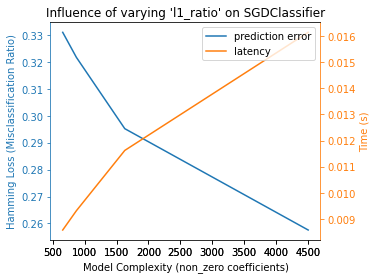

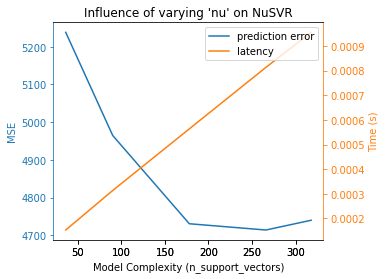

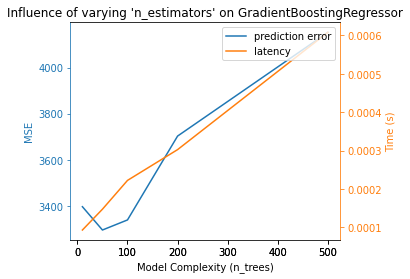

In [10]:
for conf in configurations:
    prediction_performances, prediction_times, complexities = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)

### Tips - Linear Algebra

- Make sure your version of NumPy is built using an optimized version of [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) / [LAPACK](https://en.wikipedia.org/wiki/LAPACK).

- Not all models benefit from BLAS & LAPACK, for example randomized decision trees or SVMs. However, a linear model built with a `BLAS DGEMM` call (via `numpy.dot`) is a huge improvement.

- Optimized BLAS/LAPACK implementations:
    - ATLAS (requires hardware-specific tuning)
    - OpenBLAS
    - MKL
    - Apple Accelerate & vecLib (MacOS)


- [libblas & liblapack installation notes](https://danielnouri.org/notes/2012/12/19/libblas-and-liblapack-issues-and-speed,-with-scipy-and-ubuntu/)

In [11]:
from numpy.distutils.system_info import get_info
print("BLAS:\t",get_info('blas_opt'))
print("LAPACK:\t",get_info('lapack_opt'))

/home/bjpcjp/.local/lib/python3.8/site-packages/numpy/distutils/system_info.py:1914: UserWarning: 
    Optimized (vendor) Blas libraries are not found.
    Falls back to netlib Blas library which has worse performance.
    A better performance should be easily gained by switching
    Blas library.
  if self._calc_info(blas):


BLAS:	 {'define_macros': [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)], 'libraries': ['blas', 'blas'], 'library_dirs': ['/home/bjpcjp/anaconda3/envs/working/lib'], 'include_dirs': ['/usr/local/include', '/usr/include', '/home/bjpcjp/anaconda3/envs/working/include'], 'language': 'c'}
LAPACK:	 {'libraries': ['lapack', 'lapack', 'blas', 'blas'], 'library_dirs': ['/home/bjpcjp/anaconda3/envs/working/lib'], 'language': 'c', 'define_macros': [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)], 'include_dirs': ['/usr/local/include', '/usr/include', '/home/bjpcjp/anaconda3/envs/working/include']}


### Tips - Working Memory Limits

- Some vectorized NumPy ops consume large amounts of temporary memory Consider limiting computation to fixed-size chunks where possible. 

- Working memory size can be accessed via `set_config` or `config_context`.

`with sklearn.config_context(working_memory=1024):
    pass <code goes here>`

### Tips - Model Compression

- Only applies to linear models, for now, in Scikit-learn.
- Whenever possible - combine model sparsity with sparse input data formats, eg `clf.fit(X_train,y_train).sparsify()`

### Tips - Model Reshaping

- Model reshaping implies selecting a portion of the available features to fit a model. If a model discards features during the learning phase we can strip them from the input. 

- It reduces memory (and therefore time) overhead of the model itself. It also allows us to discard explicit feature selection components in a pipeline once we know which features to keep from a previous run. Finally, it can reduce processing time and I/O usage upstream in the data access and feature extraction layers by not collecting features that are discarded by the model. 

- If raw data comes from a database, write simpler and queries or reduce I/O usage by making the queries return lighter records. 

- Currently scikit-learn reshaping is manual. In the case of sparse input (particularly in CSR format), it is generally sufficient to not generate the relevant features, leaving their columns empty.

### [Example: measure prediction latency, various estimators, bulk vs atomic mode](https://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html)

In [1]:
from collections import defaultdict

import time
import gc
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle

In [2]:
def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()


def atomic_benchmark_estimator(estimator, X_test, verbose=False):
    """Measure runtime prediction of each instance."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_instances, dtype=float)
    for i in range(n_instances):
        instance = X_test[[i], :]
        start = time.time()
        estimator.predict(instance)
        runtimes[i] = time.time() - start
    if verbose:
        print("atomic_benchmark runtimes:", min(runtimes), np.percentile(
            runtimes, 50), max(runtimes))
    return runtimes


def bulk_benchmark_estimator(estimator, X_test, n_bulk_repeats, verbose):
    """Measure runtime prediction of the whole input."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_bulk_repeats, dtype=float)
    for i in range(n_bulk_repeats):
        start = time.time()
        estimator.predict(X_test)
        runtimes[i] = time.time() - start
    runtimes = np.array(list(map(lambda x: x / float(n_instances), runtimes)))
    if verbose:
        print("bulk_benchmark runtimes:", min(runtimes), np.percentile(
            runtimes, 50), max(runtimes))
    return runtimes

Benchmarking SGDRegressor(alpha=0.01, l1_ratio=0.25, penalty='elasticnet', tol=0.0001)
Benchmarking RandomForestRegressor()
Benchmarking SVR()


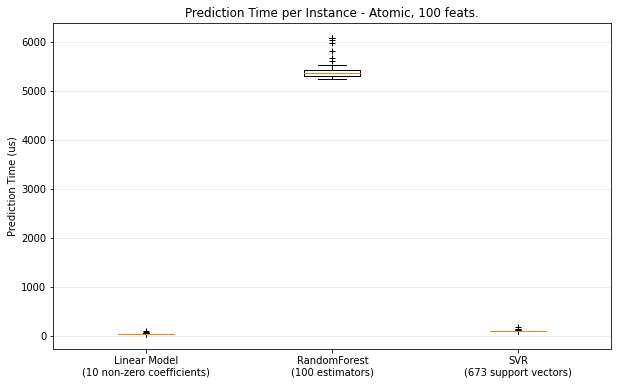

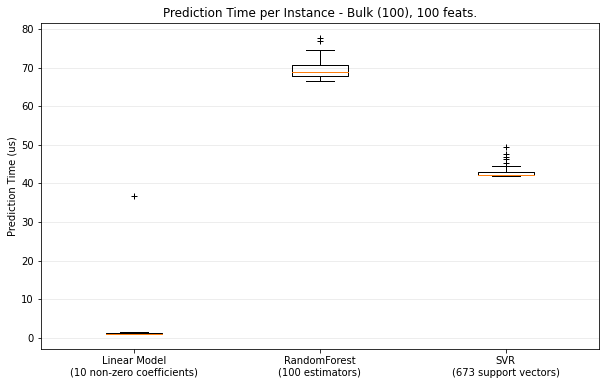

benchmarking with 100 features
benchmarking with 250 features
benchmarking with 500 features


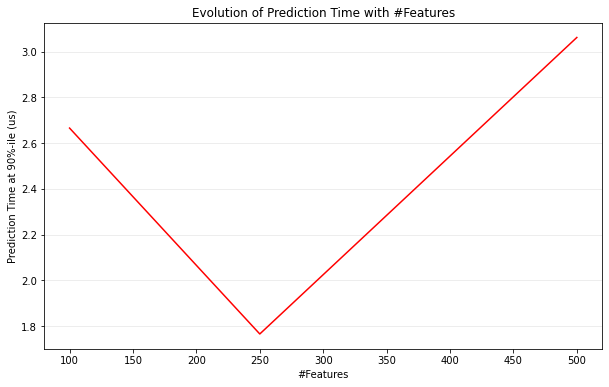

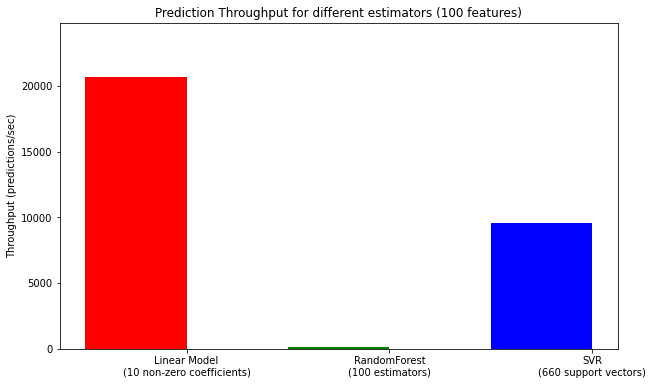

example run in 8.42s


In [3]:
def benchmark_estimator(estimator, X_test, n_bulk_repeats=30, verbose=False):
    """
    Measure runtimes of prediction in both atomic and bulk mode.

    Parameters
    ----------
    estimator : already trained estimator supporting `predict()`
    X_test : test input
    n_bulk_repeats : how many times to repeat when evaluating bulk mode

    Returns
    -------
    atomic_runtimes, bulk_runtimes : a pair of `np.array` which contain the
    runtimes in seconds.

    """
    atomic_runtimes = atomic_benchmark_estimator(estimator, X_test, verbose)
    bulk_runtimes = bulk_benchmark_estimator(estimator, X_test, n_bulk_repeats,
                                             verbose)
    return atomic_runtimes, bulk_runtimes


def generate_dataset(n_train, n_test, n_features, noise=0.1, verbose=False):
    """Generate a regression dataset with the given parameters."""
    if verbose:
        print("generating dataset...")

    X, y, coef = make_regression(n_samples=n_train + n_test,
                                 n_features=n_features, noise=noise, coef=True)

    random_seed = 13
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_train, test_size=n_test, random_state=random_seed)
    X_train, y_train = shuffle(X_train, y_train, random_state=random_seed)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
    y_test = y_scaler.transform(y_test[:, None])[:, 0]

    gc.collect()
    if verbose:
        print("ok")
    return X_train, y_train, X_test, y_test


def boxplot_runtimes(runtimes, pred_type, configuration):
    """
    Plot a new `Figure` with boxplots of prediction runtimes.

    Parameters
    ----------
    runtimes : list of `np.array` of latencies in micro-seconds
    cls_names : list of estimator class names that generated the runtimes
    pred_type : 'bulk' or 'atomic'

    """

    fig, ax1 = plt.subplots(figsize=(10, 6))
    bp = plt.boxplot(runtimes, )

    cls_infos = ['%s\n(%d %s)' % (estimator_conf['name'],
                                  estimator_conf['complexity_computer'](
                                      estimator_conf['instance']),
                                  estimator_conf['complexity_label']) for
                 estimator_conf in configuration['estimators']]
    plt.setp(ax1, xticklabels=cls_infos)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set_axisbelow(True)
    ax1.set_title('Prediction Time per Instance - %s, %d feats.' % (
        pred_type.capitalize(),
        configuration['n_features']))
    ax1.set_ylabel('Prediction Time (us)')

    plt.show()


def benchmark(configuration):
    """Run the whole benchmark."""
    X_train, y_train, X_test, y_test = generate_dataset(
        configuration['n_train'], configuration['n_test'],
        configuration['n_features'])

    stats = {}
    for estimator_conf in configuration['estimators']:
        print("Benchmarking", estimator_conf['instance'])
        estimator_conf['instance'].fit(X_train, y_train)
        gc.collect()
        a, b = benchmark_estimator(estimator_conf['instance'], X_test)
        stats[estimator_conf['name']] = {'atomic': a, 'bulk': b}

    cls_names = [estimator_conf['name'] for estimator_conf in configuration[
        'estimators']]
    runtimes = [1e6 * stats[clf_name]['atomic'] for clf_name in cls_names]
    boxplot_runtimes(runtimes, 'atomic', configuration)
    runtimes = [1e6 * stats[clf_name]['bulk'] for clf_name in cls_names]
    boxplot_runtimes(runtimes, 'bulk (%d)' % configuration['n_test'],
                     configuration)


def n_feature_influence(estimators, n_train, n_test, n_features, percentile):
    """
    Estimate influence of the number of features on prediction time.

    Parameters
    ----------

    estimators : dict of (name (str), estimator) to benchmark
    n_train : nber of training instances (int)
    n_test : nber of testing instances (int)
    n_features : list of feature-space dimensionality to test (int)
    percentile : percentile at which to measure the speed (int [0-100])

    Returns:
    --------

    percentiles : dict(estimator_name,
                       dict(n_features, percentile_perf_in_us))

    """
    percentiles = defaultdict(defaultdict)
    for n in n_features:
        print("benchmarking with %d features" % n)
        X_train, y_train, X_test, y_test = generate_dataset(n_train, n_test, n)
        for cls_name, estimator in estimators.items():
            estimator.fit(X_train, y_train)
            gc.collect()
            runtimes = bulk_benchmark_estimator(estimator, X_test, 30, False)
            percentiles[cls_name][n] = 1e6 * np.percentile(runtimes,
                                                           percentile)
    return percentiles


def plot_n_features_influence(percentiles, percentile):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    colors = ['r', 'g', 'b']
    for i, cls_name in enumerate(percentiles.keys()):
        x = np.array(sorted([n for n in percentiles[cls_name].keys()]))
        y = np.array([percentiles[cls_name][n] for n in x])
        plt.plot(x, y, color=colors[i], )
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    ax1.set_axisbelow(True)
    ax1.set_title('Evolution of Prediction Time with #Features')
    ax1.set_xlabel('#Features')
    ax1.set_ylabel('Prediction Time at %d%%-ile (us)' % percentile)
    plt.show()


def benchmark_throughputs(configuration, duration_secs=0.1):
    """benchmark throughput for different estimators."""
    X_train, y_train, X_test, y_test = generate_dataset(
        configuration['n_train'], configuration['n_test'],
        configuration['n_features'])
    throughputs = dict()
    for estimator_config in configuration['estimators']:
        estimator_config['instance'].fit(X_train, y_train)
        start_time = time.time()
        n_predictions = 0
        while (time.time() - start_time) < duration_secs:
            estimator_config['instance'].predict(X_test[[0]])
            n_predictions += 1
        throughputs[estimator_config['name']] = n_predictions / duration_secs
    return throughputs


def plot_benchmark_throughput(throughputs, configuration):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['r', 'g', 'b']
    cls_infos = ['%s\n(%d %s)' % (estimator_conf['name'],
                                  estimator_conf['complexity_computer'](
                                      estimator_conf['instance']),
                                  estimator_conf['complexity_label']) for
                 estimator_conf in configuration['estimators']]
    cls_values = [throughputs[estimator_conf['name']] for estimator_conf in
                  configuration['estimators']]
    plt.bar(range(len(throughputs)), cls_values, width=0.5, color=colors)
    ax.set_xticks(np.linspace(0.25, len(throughputs) - 0.75, len(throughputs)))
    ax.set_xticklabels(cls_infos, fontsize=10)
    ymax = max(cls_values) * 1.2
    ax.set_ylim((0, ymax))
    ax.set_ylabel('Throughput (predictions/sec)')
    ax.set_title('Prediction Throughput for different estimators (%d '
                 'features)' % configuration['n_features'])
    plt.show()


# #############################################################################
# Main code

start_time = time.time()

# #############################################################################
# Benchmark bulk/atomic prediction speed for various regressors
configuration = {
    'n_train': int(1e3),
    'n_test': int(1e2),
    'n_features': int(1e2),
    'estimators': [
        {'name': 'Linear Model',
         'instance': SGDRegressor(penalty='elasticnet', alpha=0.01,
                                  l1_ratio=0.25, tol=1e-4),
         'complexity_label': 'non-zero coefficients',
         'complexity_computer': lambda clf: np.count_nonzero(clf.coef_)},
        {'name': 'RandomForest',
         'instance': RandomForestRegressor(),
         'complexity_label': 'estimators',
         'complexity_computer': lambda clf: clf.n_estimators},
        {'name': 'SVR',
         'instance': SVR(kernel='rbf'),
         'complexity_label': 'support vectors',
         'complexity_computer': lambda clf: len(clf.support_vectors_)},
    ]
}
benchmark(configuration)

# benchmark n_features influence on prediction speed
percentile = 90
percentiles = n_feature_influence({'ridge': Ridge()},
                                  configuration['n_train'],
                                  configuration['n_test'],
                                  [100, 250, 500], percentile)
plot_n_features_influence(percentiles, percentile)

# benchmark throughput
throughputs = benchmark_throughputs(configuration)
plot_benchmark_throughput(throughputs, configuration)

stop_time = time.time()
print("example run in %.2fs" % (stop_time - start_time))